In [29]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(0, '../src')

from pathlib import Path
import pandas as pd
from zipfile import ZipFile
import numpy as np
from sklearn.model_selection import train_test_split
from imblearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from models import run_model_dep_classification, append_df_metrics, append_df_importances, create_df_importances
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from models import classification_metrics
import copy
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
import pydot
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from models import plot_roc_curve, plot_cm
from models import prune_duplicate_leaves

PNS_DATA = Path('../data/processed/PNS_2019/all.zip').resolve()
zip_pns = ZipFile(PNS_DATA)
df = pd.read_csv(zip_pns.open(zip_pns.namelist()[0]), sep=",", low_memory=False)

PATH_GEN_DATA = Path('generated_data/pns_data_models').resolve()

def process_df(df_i, remove_na=True):
    df_i = copy.deepcopy(df_i)
    if remove_na:
        df_i = df_i.dropna()
    return df_i.drop(['r_norte', 'r_nordeste', 'r_sudeste', 'r_sul', 'r_centro_oeste'], axis=1)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Criação das variaveis de interesse

#### Label

In [30]:
# Target
df['depression'] = np.where(df['phq9_total'].isna(), np.nan, np.where(df['phq9_total'] >= 10, 1, 0))
df = df.dropna(subset=['depression'])
df['depression'].value_counts()

depression
0.0    58451
1.0     6949
Name: count, dtype: int64

#### Features derivadas

In [31]:
# Alimentos in natura ou minimamente processado
innatura = ['P00601','P00602', 'P00603', 'P00604', 'P00605', 'P00607', 'P00608', 'P00609', 'P00610', 'P00611', 'P00612', 'P00613']
df_innatura = df[innatura]
df_innatura['qst_innatura'] = (df_innatura == 1.0).sum(axis=1)
# Alimentos ultraprocessados
ultraprocessados = ['P00614', 'P00615', 'P00616', 'P00617', 'P00618', 'P00619', 'P00620', 'P00621', 'P00622', 'P00623']
df_upf = df[ultraprocessados]
df_upf['qst_upf'] = (df_upf == 1.0).sum(axis=1)

# A literatura não usa a porcentagem de ultraprocessados do prato como análise. O artigo 'Food consumption and depression among Brazilian adults: results from the Brazilian National Health Survey, 2013'
# Usa como base o número de perguntas respondidas 'Sim' nos alimentos ultraprocessados das ultimas 24hrs
df['per_innatura'] = df_innatura['qst_innatura'] / (df_innatura['qst_innatura'] + df_upf['qst_upf']) * 100
df['per_upf'] = df_upf['qst_upf'] / (df_innatura['qst_innatura'] + df_upf['qst_upf']) * 100
df['qst_upf'] = df_upf['qst_upf'] # Baseado no artigo

def classify_upf(row):
    value = row['qst_upf']

    if  0 <= value < 2:
        return 1
    elif value < 4:
        return 2
    elif value < 6:
        return 3
    elif value < 8:
        return 4
    elif value <= 10:
        return 5

    return np.nan # questionario não respondido

df['upf_severity'] = df.apply(classify_upf, axis=1)


def count_imc(row):
    height = row['altura']
    weight = row['peso']

    imc = weight/np.square(height/100)   # Peso está em kg e altura em cm, no calculo do imc é kg/m^2
    return imc

df['imc'] = df.apply(count_imc, axis=1)


def classify_imc(row):
    value = row['imc']

    if  0 <= value < 18.5:
        return 1  # Baixo peso
    elif value < 24.9:
        return 2 # Eutrofia/peso adequado
    elif value < 29.9:
        return 3   # Sobrepeso
    elif value >= 30:
        return 4  # Obesidade

    return np.nan # questionario não respondido

df['class_imc'] = df.apply(classify_imc, axis=1)


def classify_idade(row):
    value = row['idade']
    if  18 <= value <= 29:
        return 1
    elif value <= 39:
        return 2
    elif value <= 49:
        return 3
    elif value <= 59:
        return 4

    return np.nan

df['class_idade'] = df.apply(classify_idade, axis=1)


# Essa variável foi criada a partir de um índice utilizado pela OMS. Na literatura, usam a pergunta 'P034' relacionada à prática de exercícios físicos nos ultimos 3 meses
df_activity = pd.DataFrame()
df_activity['minutes_per_week'] = df['P03702'] * df['P035']

vigorous_activities = [3.0, 4.0, 5.0, 6.0, 12.0, 13.0, 15.0]
moderated_activities = [1.0, 2.0, 7.0, 8.0, 9.0, 10.0, 11.0, 14.0, 16.0, 17.0]
df_activity['time_vigorous'] = df_activity['minutes_per_week'].loc[df['P036'].isin(vigorous_activities)]
df_activity['time_moderated'] = df_activity['minutes_per_week'].loc[df['P036'].isin(moderated_activities)]

df_activity['activity_class'] = 0
df_activity.loc[df_activity['minutes_per_week'].isna(), 'activity_class'] = np.nan
df_activity.loc[(df_activity['time_vigorous'] >= 75) | (df_activity['time_moderated'] >= 150), 'activity_class'] = 1

df['activity_class'] = df_activity['activity_class']
df['exerc_fisico'] = np.where(df['P034'].isin([1.0]), 1, np.where(df['P034'] == 2.0, 0, np.nan))
df['tabagismo'] = np.where(df['P050'].isin([1.0, 2.0]), 1, np.where(df['P050'] == 3.0, 0, np.nan))

# Na literatura eles usam outra variável para analisar o consumo alcoolico
# df['cons_alcool'] = np.where(df['P02801'] >= 1, 1, 0)
# df['cons_alcool'] = np.where(df['P02801'].isna(), np.nan, df['cons_alcool'])

# Olhar artigo 'Food consumption and depression among Brazilian adults: results from the Brazilian National Health Survey, 2013'
df['cons_alcool'] = np.where(df['P027'].isin([2.0, 3.0]), 1, np.where(df['P027'] == 1.0, 0, np.nan))

df = df[df['P005'] != 1.0] #Retirando as grávidas da análise

df['obesidade'] = np.where(df['class_imc'].isna(), np.nan, np.where(df['class_imc'] >= 4, 1, 0))

# Limitação da análise por idades que se adequam ao PHQ9 baseado no artigo 'Food consumption and depression among Brazilian adults: results from the Brazilian National Health Survey, 2013'
df = df[(df['idade'] >= 18) & (df['idade'] <= 59)]


regiao_mapping = {
    'r_norte': [11, 12, 13, 14, 15, 16, 17],
    'r_nordeste': [21, 22, 23, 24, 25, 26, 27, 28, 29],
    'r_sudeste': [31, 32, 33, 35],
    'r_sul': [41, 42, 43],
    'r_centro_oeste': [50, 51, 52, 53]
}

for regiao, estados in regiao_mapping.items():
    df[regiao] = df['uf'].apply(lambda x: int(x in estados))


df['class_renda'] = np.where(df['renda_pc'].isin([4.0, 5.0, 6.0, 7.0]), 1, np.where(df['renda_pc'].isin([1.0, 2.0, 3.0]), 0, np.nan))

/tmp/ipykernel_23776/1486364925.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_innatura['qst_innatura'] = (df_innatura == 1.0).sum(axis=1)
/tmp/ipykernel_23776/1486364925.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_upf['qst_upf'] = (df_upf == 1.0).sum(axis=1)


In [32]:
df['depression'].value_counts()

depression
0.0    57816
1.0     6848
Name: count, dtype: int64

# Análise de dados faltantes

#### População total

In [33]:
print('Faltantes em Q092 - pergunta do diagnóstico de depressão: ', df['Q092'].isna().sum(), 'Perc:',  round(df['Q092'].isna().sum()/len(df['Q092'])*100, 3))
print('Faltantes em PHQ9_total - classificação de grau de depressão: ', df['phq9_total'].isna().sum(), 'Perc:',  round(df['phq9_total'].isna().sum()/len(df['phq9_total'])*100, 3))
print('Faltantes em vive_conjugue - classificação do estado civil: ', df['vive_conjugue'].isna().sum(), 'Perc:',  round(df['vive_conjugue'].isna().sum()/len(df['vive_conjugue'])*100, 3))
print('Faltantes em class_idade - classificação de idade: ', df['class_idade'].isna().sum(), 'Perc:',  round(df['class_idade'].isna().sum()/len(df['class_idade'])*100, 3))
print('Faltantes em cor - cor ou raça autodeclaradas: ', df['cor'].isna().sum(), 'Perc:',  round(df['cor'].isna().sum()/len(df['cor'])*100, 3))

print('Faltantes em UPF_severity - classificação de consumo de ultraprocessados: ', df['upf_severity'].isna().sum(), 'Perc:',  round(df['upf_severity'].isna().sum()/len(df['upf_severity'])*100, 3))
print('Faltantes em exerc_fisico - classificação de atividade física: ', df['exerc_fisico'].isna().sum(), 'Perc:',  round(df['exerc_fisico'].isna().sum()/len(df['exerc_fisico'])*100, 3))
print('Faltantes em tabagist - classificação de tabagismo: ', df['tabagismo'].isna().sum(), 'Perc:',  round(df['tabagismo'].isna().sum()/len(df['tabagismo'])*100, 3))
print('Faltantes em cons_alcool - classificação do consumo de álcool: ', df['cons_alcool'].isna().sum(), 'Perc:',  round(df['cons_alcool'].isna().sum()/len(df['cons_alcool'])*100, 3))

print('Faltantes em Q120 - pergunta do diagnóstico de cancer: ', df['Q120'].isna().sum(), 'Perc:',  round(df['Q120'].isna().sum()/len(df['Q120'])*100, 3))
print('Faltantes em Q00201 - diagnotisco pressão alta: ', df['Q00201'].isna().sum(), 'Perc:',  round(df['Q00201'].isna().sum()/len(df['Q00201'])*100, 3))
print('Faltantes em Q03001 - diagnostico diabetes: ', df['Q03001'].isna().sum(), 'Perc:',  round(df['Q03001'].isna().sum()/len(df['Q03001'])*100, 3))
print('Faltantes em Q06306 - diagnostico cardiovascular : ', df['Q06306'].isna().sum(), 'Perc:',  round(df['Q06306'].isna().sum()/len(df['Q06306'])*100, 3))
print('Faltantes em Q060 - diagnostico colesterol alto: ', df['Q060'].isna().sum(), 'Perc:',  round(df['Q060'].isna().sum()/len(df['Q060'])*100, 3))
print('Faltantes em Q068 - diagnostico de AVC: ', df['Q068'].isna().sum(), 'Perc:',  round(df['Q068'].isna().sum()/len(df['Q068'])*100, 3))
print('Faltantes em Q079 - diagnostico de artrite: ', df['Q079'].isna().sum(), 'Perc:',  round(df['Q079'].isna().sum()/len(df['Q079'])*100, 3))
print('Faltantes em class_imc - classificação de imc: ', df['class_imc'].isna().sum(), 'Perc:',  round(df['class_imc'].isna().sum()/len(df['class_imc'])*100, 3))

Faltantes em Q092 - pergunta do diagnóstico de depressão:  0 Perc: 0.0
Faltantes em PHQ9_total - classificação de grau de depressão:  0 Perc: 0.0
Faltantes em vive_conjugue - classificação do estado civil:  0 Perc: 0.0
Faltantes em class_idade - classificação de idade:  0 Perc: 0.0
Faltantes em cor - cor ou raça autodeclaradas:  0 Perc: 0.0
Faltantes em UPF_severity - classificação de consumo de ultraprocessados:  0 Perc: 0.0
Faltantes em exerc_fisico - classificação de atividade física:  0 Perc: 0.0
Faltantes em tabagist - classificação de tabagismo:  0 Perc: 0.0
Faltantes em cons_alcool - classificação do consumo de álcool:  0 Perc: 0.0
Faltantes em Q120 - pergunta do diagnóstico de cancer:  0 Perc: 0.0
Faltantes em Q00201 - diagnotisco pressão alta:  1495 Perc: 2.312
Faltantes em Q03001 - diagnostico diabetes:  5410 Perc: 8.366
Faltantes em Q06306 - diagnostico cardiovascular :  0 Perc: 0.0
Faltantes em Q060 - diagnostico colesterol alto:  6369 Perc: 9.849
Faltantes em Q068 - diagno

## População considerada depressiva (PHQ9>=10)

In [34]:
new_df = df[df['phq9_total'] >= 10].copy()
print('Faltantes em Q092 - pergunta do diagnóstico de depressão: ', new_df['Q092'].isna().sum(), 'Perc:',  round(new_df['Q092'].isna().sum()/len(new_df['Q092'])*100, 3))
print('Faltantes em vive_conjugue - classificação do estado civil: ', new_df['vive_conjugue'].isna().sum(), 'Perc:',  round(new_df['vive_conjugue'].isna().sum()/len(new_df['vive_conjugue'])*100, 3))
print('Faltantes em class_idade - classificação de idade: ', new_df['class_idade'].isna().sum(), 'Perc:',  round(new_df['class_idade'].isna().sum()/len(new_df['class_idade'])*100, 3))
print('Faltantes em cor - cor ou raça autodeclaradas: ', new_df['cor'].isna().sum(), 'Perc:',  round(new_df['cor'].isna().sum()/len(new_df['cor'])*100, 3))

print('Faltantes em UPF_severity - classificação de consumo de ultraprocessados: ', new_df['upf_severity'].isna().sum(), 'Perc:',  round(new_df['upf_severity'].isna().sum()/len(new_df['upf_severity'])*100, 3))
print('Faltantes em activity_class - classificação de atividade física: ', new_df['activity_class'].isna().sum(), 'Perc:',  round(new_df['activity_class'].isna().sum()/len(new_df['activity_class'])*100, 3))
print('Faltantes em tabagist - classificação de tabagismo: ', new_df['tabagismo'].isna().sum(), 'Perc:',  round(new_df['tabagismo'].isna().sum()/len(new_df['tabagismo'])*100, 3))
print('Faltantes em cons_alcool - clasificação do consumo de álcool: ', new_df['cons_alcool'].isna().sum(), 'Perc:',  round(new_df['cons_alcool'].isna().sum()/len(new_df['cons_alcool'])*100, 3))

print('Faltantes em Q120 - pergunta do diagnóstico de cancer: ', new_df['Q120'].isna().sum(), 'Perc:',  round(new_df['Q120'].isna().sum()/len(new_df['Q120'])*100, 3))
print('Faltantes em Q00201 - diagnotisco pressão alta: ', new_df['Q00201'].isna().sum(), 'Perc:',  round(new_df['Q00201'].isna().sum()/len(new_df['Q00201'])*100, 3))
print('Faltantes em Q03001 - diagnostico diabetes: ', new_df['Q03001'].isna().sum(), 'Perc:',  round(new_df['Q03001'].isna().sum()/len(new_df['Q03001'])*100, 3))
print('Faltantes em Q06306 - diagnostico cardiovascular : ', new_df['Q06306'].isna().sum(), 'Perc:',  round(new_df['Q06306'].isna().sum()/len(new_df['Q06306'])*100, 3))
print('Faltantes em Q060 - diagnostico colesterol alto: ', new_df['Q060'].isna().sum(), 'Perc:',  round(new_df['Q060'].isna().sum()/len(new_df['Q060'])*100, 3))
print('Faltantes em Q068 - diagnostico de AVC: ', new_df['Q068'].isna().sum(), 'Perc:',  round(new_df['Q068'].isna().sum()/len(new_df['Q068'])*100, 3))
print('Faltantes em Q079 - diagnostico de artrite: ', new_df['Q079'].isna().sum(), 'Perc:',  round(new_df['Q079'].isna().sum()/len(new_df['Q079'])*100, 3))
print('Faltantes em class_imc - classificação de imc: ', new_df['class_imc'].isna().sum(), 'Perc:',  round(new_df['class_imc'].isna().sum()/len(new_df['class_imc'])*100, 3))

Faltantes em Q092 - pergunta do diagnóstico de depressão:  0 Perc: 0.0
Faltantes em vive_conjugue - classificação do estado civil:  0 Perc: 0.0
Faltantes em class_idade - classificação de idade:  0 Perc: 0.0
Faltantes em cor - cor ou raça autodeclaradas:  0 Perc: 0.0
Faltantes em UPF_severity - classificação de consumo de ultraprocessados:  0 Perc: 0.0
Faltantes em activity_class - classificação de atividade física:  4570 Perc: 66.735
Faltantes em tabagist - classificação de tabagismo:  0 Perc: 0.0
Faltantes em cons_alcool - clasificação do consumo de álcool:  0 Perc: 0.0
Faltantes em Q120 - pergunta do diagnóstico de cancer:  0 Perc: 0.0
Faltantes em Q00201 - diagnotisco pressão alta:  71 Perc: 1.037
Faltantes em Q03001 - diagnostico diabetes:  353 Perc: 5.155
Faltantes em Q06306 - diagnostico cardiovascular :  0 Perc: 0.0
Faltantes em Q060 - diagnostico colesterol alto:  443 Perc: 6.469
Faltantes em Q068 - diagnostico de AVC:  0 Perc: 0.0
Faltantes em Q079 - diagnostico de artrite:  

# Modelos

In [35]:
df_metrics_all = pd.DataFrame()
df_importances_all = pd.DataFrame()

### Seleção das variaveis e ajustes

In [36]:
df_total = pd.DataFrame()

df_total['exerc_fisico'] = df['exerc_fisico']
df_total['tabagismo'] = df['tabagismo']
df_total['cons_alcool'] = df['cons_alcool']
df_total['cancer'] = df['Q120']
df_total['hipertensao'] = df['Q00201']
df_total['diabetes'] = df['Q03001']
df_total['cardiovascular'] = df['Q06306']
df_total['hipercolesterolemia'] = df['Q060']
df_total['avc'] = df['Q068']
df_total['artrite'] = df['Q079']
df_total['obesidade'] = df['obesidade']
df_total['depression'] = df['depression']
df_total['sexo'] = df['sexo']
df_total['estado_civil'] = df['vive_conjugue']
df_total = df_total.replace(2.0, 0.0)
df_total['class_renda'] = df['class_renda']

df_total['r_norte'] = df['r_norte']
df_total['r_nordeste'] = df['r_nordeste']
df_total['r_sudeste'] = df['r_sudeste']
df_total['r_sul'] = df['r_sul']
df_total['r_centro_oeste'] = df['r_centro_oeste']

df_total['escolaridade'] = df['escolaridade_agregada']
df_total['upf'] = df['qst_upf']
df_total['class_idade'] = df['class_idade']

df_train_total, df_test_total = train_test_split(df_total, test_size=0.3, random_state=42)

df_total_t = copy.deepcopy(df_total)

print("Número de dados totais: ", len(df_total_t))
print("Número de dados filtrados: ", len(df_total_t.dropna()))
print("Porcentagem de dados faltantes: {:.2f}".format(100*(1 - (len(df_total_t.dropna()) / len(df_total_t)))))

print()

df_total_t = copy.deepcopy(df_train_total)
print("Número de dados totais (treino): ", len(df_total_t))
print("Número de dados filtrados (treino): ", len(df_total_t.dropna()))
print("Porcentagem de dados faltantes (treino): {:.2f}".format(100*(1 - (len(df_total_t.dropna()) / len(df_total_t)))))

print()

df_total_t = copy.deepcopy(df_test_total)
print("Número de dados totais (teste): ", len(df_total_t))
print("Número de dados filtrados (teste): ", len(df_total_t.dropna()))
print("Porcentagem de dados faltantes (teste): {:.2f}".format(100*(1 - (len(df_total_t.dropna()) / len(df_total_t)))))

Número de dados totais:  64664
Número de dados filtrados:  49843
Porcentagem de dados faltantes: 22.92

Número de dados totais (treino):  45264
Número de dados filtrados (treino):  34932
Porcentagem de dados faltantes (treino): 22.83

Número de dados totais (teste):  19400
Número de dados filtrados (teste):  14911
Porcentagem de dados faltantes (teste): 23.14


In [37]:
data = []
for x in df_total.columns:
    data.append([x, df_total[x].isna().sum()])

pd.DataFrame(data)

,0,1
0,exerc_fisico,0
1,tabagismo,0
2,cons_alcool,0
3,cancer,0
4,hipertensao,1495
5,diabetes,5410
6,cardiovascular,0
7,hipercolesterolemia,6369
8,avc,0
9,artrite,0


### Modelo apenas com habitos

In [38]:
df_habitos = df_train_total[['upf', 'exerc_fisico', 'tabagismo', 'cons_alcool', 'depression']].dropna()
X = df_habitos.drop('depression', axis=1)
y = df_habitos['depression']

model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)

model, df_metrics = run_model_dep_classification(model, X, y)
df_importances = create_df_importances(X.columns, model.coef_[0], model.intercept_[0])

display(df_metrics)
display(df_importances)

df_metrics_all = append_df_metrics(df_metrics_all, df_metrics, 'log_apenas_habitos')
df_importances_all = append_df_importances(df_importances_all, df_importances, 'log_apenas_habitos')

exp,train_acc,test_acc,test_acc_std,train_precision,test_precision,test_precision_std,train_recall,test_recall,test_recall_std,train_f1,test_f1,test_f1_std,train_auc,test_auc,test_auc_std
0,0.559495,0.5568,0.004056,0.129505,0.129419,0.004002,0.547017,0.550957,0.017824,0.209429,0.209602,0.006519,0.554001,0.554228,0.009659


,value
name,
intercept,0.088410
upf,0.032934
exerc_fisico,-0.311056
tabagismo,0.426645
cons_alcool,-0.257500


### Modelo apenas com as doenças cronicas

In [39]:
df_doencas = df_train_total[['cancer', 'hipertensao', 'diabetes', 'cardiovascular', 'hipercolesterolemia', 'avc', 'artrite', 'obesidade', 'depression']].dropna()
X = df_doencas.drop('depression', axis=1)
y = df_doencas['depression']

model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)

model, df_metrics = run_model_dep_classification(model, X, y)
df_importances = create_df_importances(X.columns, model.coef_[0], model.intercept_[0])

display(df_metrics)
display(df_importances)

df_metrics_all = append_df_metrics(df_metrics_all, df_metrics, 'log_apenas_dcnt')
df_importances_all = append_df_importances(df_importances_all, df_importances, 'log_apenas_dcnt')

exp,train_acc,test_acc,test_acc_std,train_precision,test_precision,test_precision_std,train_recall,test_recall,test_recall_std,train_f1,test_f1,test_f1_std,train_auc,test_auc,test_auc_std
0,0.728369,0.718348,0.020054,0.189948,0.186161,0.006638,0.443285,0.453719,0.02684,0.265941,0.263577,0.004461,0.603625,0.602554,0.003663


,value
name,
intercept,-0.359667
cancer,0.598822
hipertensao,0.332995
diabetes,0.442612
cardiovascular,0.817326
hipercolesterolemia,0.415578
avc,0.827416
artrite,0.970965
obesidade,0.171847


### Modelo com doenças e hábitos

In [40]:
df_total = df_train_total[['upf', 'exerc_fisico', 'tabagismo', 'cons_alcool', 'cancer', 'hipertensao', 'diabetes', 'cardiovascular', 'hipercolesterolemia', 'avc', 'artrite', 'obesidade', 'depression']].dropna()
X = df_total.drop('depression', axis=1)
y = df_total['depression']

model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)

model, df_metrics = run_model_dep_classification(model, X, y)
df_importances = create_df_importances(X.columns, model.coef_[0], model.intercept_[0])

display(df_metrics)
display(df_importances)

df_metrics_all = append_df_metrics(df_metrics_all, df_metrics, 'log_apenas_habitos_dcnt')
df_importances_all = append_df_importances(df_importances_all, df_importances, 'log_apenas_habitos_dcnt')

exp,train_acc,test_acc,test_acc_std,train_precision,test_precision,test_precision_std,train_recall,test_recall,test_recall_std,train_f1,test_f1,test_f1_std,train_auc,test_auc,test_auc_std
0,0.694928,0.697371,0.002406,0.18432,0.18569,0.002114,0.510436,0.509985,0.008765,0.27084,0.272245,0.003326,0.6142,0.615377,0.003748


,value
name,
intercept,-0.375233
upf,0.050807
exerc_fisico,-0.268638
tabagismo,0.496894
cons_alcool,-0.168735
cancer,0.610721
hipertensao,0.320104
diabetes,0.427649
cardiovascular,0.793583


### Modelo só com variáveis sociodemográficas

In [41]:
df_total = df_train_total[['sexo', 'estado_civil', 'escolaridade', 'class_idade', 'class_renda', 'depression']].dropna()
X = df_total.drop('depression', axis=1)
y = df_total['depression']

model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)

model, df_metrics = run_model_dep_classification(model, X, y)
df_importances = create_df_importances(X.columns, model.coef_[0], model.intercept_[0])

display(df_metrics)
display(df_importances)

df_metrics_all = append_df_metrics(df_metrics_all, df_metrics, 'log_apenas_sociodemo')
df_importances_all = append_df_importances(df_importances_all, df_importances, 'log_apenas_sociodemo')

exp,train_acc,test_acc,test_acc_std,train_precision,test_precision,test_precision_std,train_recall,test_recall,test_recall_std,train_f1,test_f1,test_f1_std,train_auc,test_auc,test_auc_std
0,0.570528,0.565586,0.005619,0.158095,0.157008,0.001924,0.697077,0.700613,0.01118,0.257736,0.25652,0.003005,0.626224,0.625013,0.004642


,value
name,
intercept,0.500695
sexo,-1.053469
estado_civil,-0.393748
escolaridade,-0.043463
class_idade,0.119753
class_renda,-0.262056


### Modelo com todas as variáveis de interesse

#### Correlações

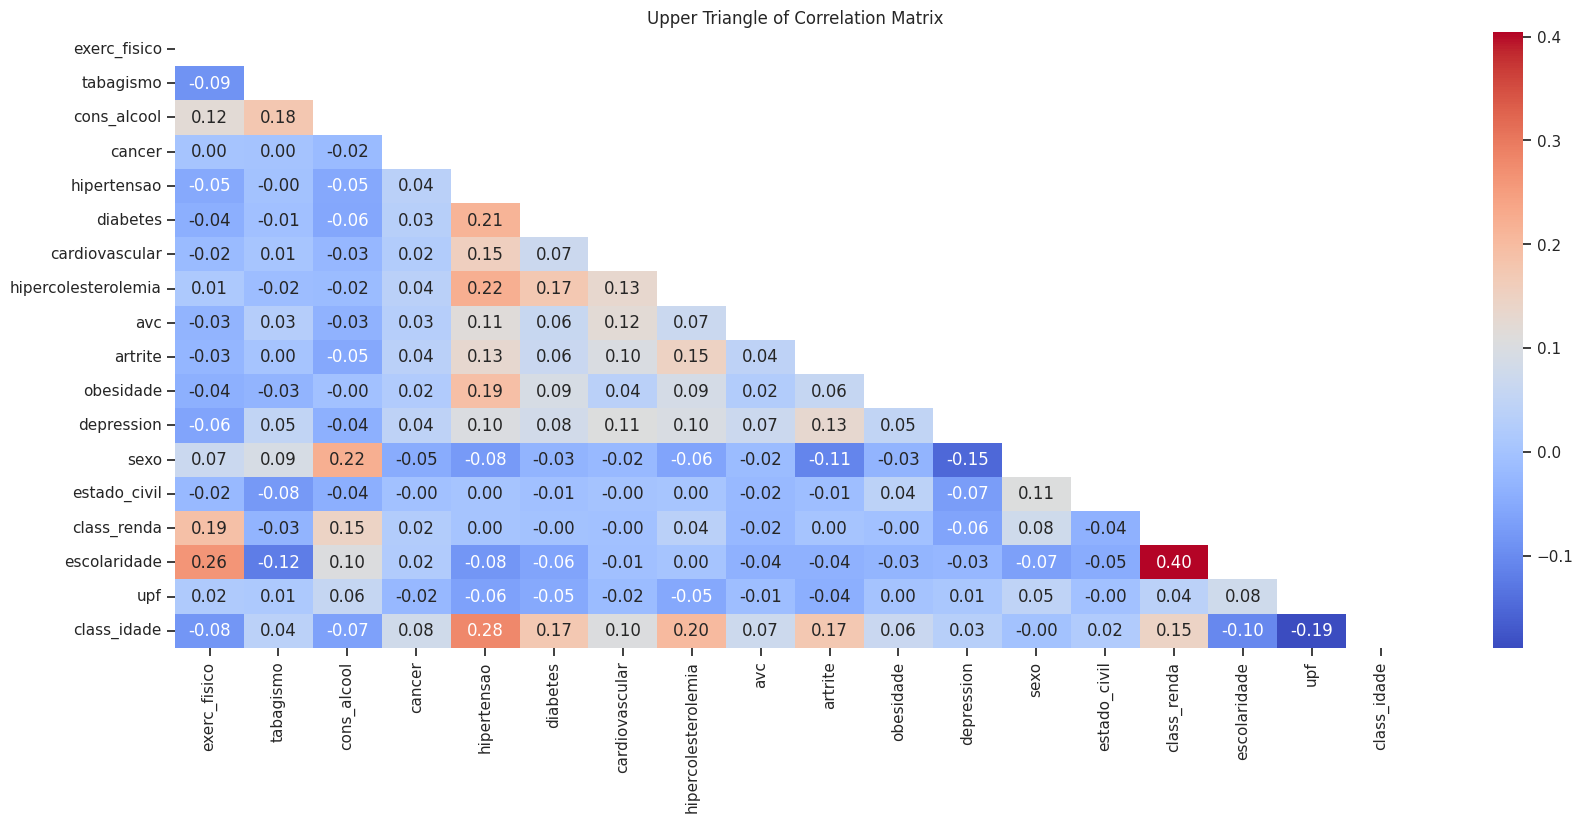

In [42]:
df_total = process_df(df_train_total)

corr_matrix = df_total.corr()
correlations = corr_matrix['depression'].abs().sort_values(ascending=False)

mask = np.triu(np.ones(corr_matrix.shape)).astype(bool)
fig, ax = plt.subplots(figsize=(20, 8))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", cmap="coolwarm", ax=ax)
ax.set_title("Upper Triangle of Correlation Matrix")
plt.show()

In [43]:
correlations.head(30)

depression             1.000000
sexo                   0.151905
artrite                0.130409
cardiovascular         0.107613
hipertensao            0.102234
hipercolesterolemia    0.098234
diabetes               0.080024
estado_civil           0.072990
avc                    0.068793
exerc_fisico           0.059380
class_renda            0.059227
tabagismo              0.052019
obesidade              0.049887
cancer                 0.043146
cons_alcool            0.038470
class_idade            0.033487
escolaridade           0.025452
upf                    0.008848
Name: depression, dtype: float64

#### Exluindo todos dados nulos

In [44]:
df_total = process_df(df_train_total)

X = df_total.drop('depression', axis=1)
y = df_total['depression']

model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)

model, df_metrics = run_model_dep_classification(model, X, y)
df_importances = create_df_importances(X.columns, model.coef_[0], model.intercept_[0])

display(df_metrics)
display(df_importances)

df_metrics_all = append_df_metrics(df_metrics_all, df_metrics, 'log_all_dropna')
df_importances_all = append_df_importances(df_importances_all, df_importances, 'log_all_dropna')

exp,train_acc,test_acc,test_acc_std,train_precision,test_precision,test_precision_std,train_recall,test_recall,test_recall_std,train_f1,test_f1,test_f1_std,train_auc,test_auc,test_auc_std
0,0.658021,0.658994,0.009137,0.192948,0.192832,0.007183,0.648205,0.644615,0.027019,0.297377,0.296821,0.010885,0.65373,0.652708,0.013558


,value
name,
intercept,0.304408
exerc_fisico,-0.227849
tabagismo,0.571207
cons_alcool,-0.023045
cancer,0.515162
hipertensao,0.345241
diabetes,0.496635
cardiovascular,0.875434
hipercolesterolemia,0.464978


#### Usando a media/mediana

In [45]:
df_total = process_df(df_train_total, remove_na=False)

X = df_total.drop('depression', axis=1)
y = df_total['depression']

model = Pipeline([
    ('imp', SimpleImputer(missing_values=np.nan, strategy='mean')),
    ('reg', LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42))
])

model, df_metrics = run_model_dep_classification(model, X, y)
df_importances = create_df_importances(X.columns, model.named_steps['reg'].coef_[0],  model.named_steps['reg'].intercept_[0])

display(df_metrics)
display(df_importances)

df_metrics_all = append_df_metrics(df_metrics_all, df_metrics, 'log_all_meanimp')
df_importances_all = append_df_importances(df_importances_all, df_importances, 'log_all_meanimp')

exp,train_acc,test_acc,test_acc_std,train_precision,test_precision,test_precision_std,train_recall,test_recall,test_recall_std,train_f1,test_f1,test_f1_std,train_auc,test_auc,test_auc_std
0,0.650981,0.65255,0.007844,0.183351,0.184,0.005031,0.657829,0.657005,0.01916,0.286772,0.287462,0.007525,0.653996,0.654511,0.009683


,value
name,
intercept,0.275359
exerc_fisico,-0.218043
tabagismo,0.544565
cons_alcool,0.001642
cancer,0.524581
hipertensao,0.349829
diabetes,0.464308
cardiovascular,0.889742
hipercolesterolemia,0.454753


In [46]:
df_total = process_df(df_train_total, remove_na=False)

X = df_total.drop('depression', axis=1)
y = df_total['depression']

model = Pipeline([
    ('imp', SimpleImputer(missing_values=np.nan, strategy='median')),
    ('reg', LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42))
])

model, df_metrics = run_model_dep_classification(model, X, y)
df_importances = create_df_importances(X.columns, model.named_steps['reg'].coef_[0],  model.named_steps['reg'].intercept_[0])

display(df_metrics)
display(df_importances)

df_metrics_all = append_df_metrics(df_metrics_all, df_metrics, 'log_all_medianimp')
df_importances_all = append_df_importances(df_importances_all, df_importances, 'log_all_medianimp')

exp,train_acc,test_acc,test_acc_std,train_precision,test_precision,test_precision_std,train_recall,test_recall,test_recall_std,train_f1,test_f1,test_f1_std,train_auc,test_auc,test_auc_std
0,0.65277,0.654251,0.00768,0.184322,0.18482,0.004762,0.658451,0.657004,0.019413,0.288018,0.288459,0.00716,0.655271,0.655463,0.009307


,value
name,
intercept,0.298838
exerc_fisico,-0.220732
tabagismo,0.549847
cons_alcool,0.002534
cancer,0.521491
hipertensao,0.358102
diabetes,0.479608
cardiovascular,0.882389
hipercolesterolemia,0.474662


### Testando SMOTE

In [47]:

# o SMOTE é uma possibilidade para podermos realizar data augmentation dos dados de pessoas consideradas depressivas
# O desbalanceio das classes é ENORME (~59k não depressivos e 7k depressivos)
# Ele olha a classe com menos quantidade de amostras e gera uma nova distribuição de acordo com as semelhanças entre vizinhos

df_total = process_df(df_train_total)

X = df_total.drop('depression', axis=1)
y = df_total['depression']

model = Pipeline([
    ('smt', SMOTE(sampling_strategy='auto', random_state=42)),
    ('reg', LogisticRegression(max_iter=1000, class_weight=None, random_state=42))
])

model, df_metrics = run_model_dep_classification(model, X, y)
df_importances = create_df_importances(X.columns, model.named_steps['reg'].coef_[0],  model.named_steps['reg'].intercept_[0])

display(df_metrics)
display(df_importances)

df_metrics_all = append_df_metrics(df_metrics_all, df_metrics, 'log_all_smote')
df_importances_all = append_df_importances(df_importances_all, df_importances, 'log_all_smote')

exp,train_acc,test_acc,test_acc_std,train_precision,test_precision,test_precision_std,train_recall,test_recall,test_recall_std,train_f1,test_f1,test_f1_std,train_auc,test_auc,test_auc_std
0,0.623869,0.621092,0.004959,0.182792,0.181344,0.004727,0.682564,0.681282,0.023523,0.288361,0.286431,0.007798,0.649528,0.647405,0.011039


,value
name,
intercept,0.751134
exerc_fisico,-0.313728
tabagismo,0.479436
cons_alcool,-0.025436
cancer,0.286695
hipertensao,0.349345
diabetes,0.312673
cardiovascular,0.749901
hipercolesterolemia,0.402993


### Ajuste Hyper-parametro

In [48]:
df_total =  process_df(df_train_total)

X = df_total.drop('depression', axis=1)
y = df_total['depression']

param_grid = {
    'reg__C': [0.1, 1.0, 10.0],
    'reg__solver': ['liblinear', 'saga'],
    'reg__max_iter': [100, 500, 1000]
}


model = Pipeline([
    ('reg', LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42))
])

grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X, y)
model_log = grid_search.best_estimator_
print("Best params: ")
print(grid_search.best_params_)

model_log, df_metrics = run_model_dep_classification(model_log, X, y)
df_importances = create_df_importances(X.columns, model_log.named_steps['reg'].coef_[0],  model_log.named_steps['reg'].intercept_[0])

display(df_metrics)
display(df_importances)

df_metrics_all = append_df_metrics(df_metrics_all, df_metrics, 'log_best_grid')
df_importances_all = append_df_importances(df_importances_all, df_importances, 'log_best_grid')

Best params: 
{'reg__C': 0.1, 'reg__max_iter': 100, 'reg__solver': 'liblinear'}


exp,train_acc,test_acc,test_acc_std,train_precision,test_precision,test_precision_std,train_recall,test_recall,test_recall_std,train_f1,test_f1,test_f1_std,train_auc,test_auc,test_auc_std
0,0.657621,0.658565,0.009316,0.192554,0.193092,0.006999,0.647179,0.647179,0.025672,0.296802,0.2974,0.010491,0.653056,0.653588,0.012998


,value
name,
intercept,0.294703
exerc_fisico,-0.226769
tabagismo,0.564752
cons_alcool,-0.023555
cancer,0.484660
hipertensao,0.347003
diabetes,0.487160
cardiovascular,0.852858
hipercolesterolemia,0.463007


### Variação fatores ao longo do curso da vida e de variaveis sociodemográficas

In [49]:
df_total = process_df(df_train_total)
df_total_raw = copy.deepcopy(df_train_total)

tests = {

    'log_class_renda_baixa': df_total[df_total['class_renda'] == 0.0].drop('class_renda', axis=1),
    'log_class_renda_alta': df_total[df_total['class_renda'] == 1.0].drop('class_renda', axis=1),

    'log_class_sexo_mulher': df_total[df_total['sexo'] == 0].drop('sexo', axis=1),
    'log_class_sexo_homem': df_total[df_total['sexo'] == 1].drop('sexo', axis=1),

    'log_class_idade_less40': df_total[df_total['class_idade'] <= 2].drop('class_idade', axis=1),
    'log_class_idade_more40': df_total[df_total['class_idade'] > 2].drop('class_idade', axis=1),

    'log_class_idade1': df_total[df_total['class_idade'] == 1].drop('class_idade', axis=1),
    'log_class_idade2': df_total[df_total['class_idade'] == 2].drop('class_idade', axis=1),
    'log_class_idade3': df_total[df_total['class_idade'] == 3].drop('class_idade', axis=1),
    'log_class_idade4': df_total[df_total['class_idade'] == 4].drop('class_idade', axis=1),


    'log_class_r_norte': process_df(df_total_raw[df_total_raw['r_norte'] == 1]),
    'log_class_r_nordeste': process_df(df_total_raw[df_total_raw['r_nordeste'] == 1]),
    'log_class_r_sudeste': process_df(df_total_raw[df_total_raw['r_sudeste'] == 1]),
    'log_class_r_sul': process_df(df_total_raw[df_total_raw['r_sul'] == 1]),
    'log_class_r_centro_oeste': process_df(df_total_raw[df_total_raw['r_centro_oeste'] == 1]),

}
for key, df_selected in tests.items():
    X = df_selected.drop('depression', axis=1)
    y = df_selected['depression']

    model = Pipeline([
        ('reg', LogisticRegression(max_iter=100, class_weight='balanced', solver='liblinear', C=10, random_state=42))
    ])

    model, df_metrics = run_model_dep_classification(model, X, y)
    df_importances = create_df_importances(X.columns, model.named_steps['reg'].coef_[0],  model.named_steps['reg'].intercept_[0])

    df_metrics_all = append_df_metrics(df_metrics_all, df_metrics, key)
    df_importances_all = append_df_importances(df_importances_all, df_importances, key)

    print("{}: {}, f1: {}".format(key, len(df_selected)/ len(df_total), df_metrics['test_f1'][0]))


log_class_renda_baixa: 0.5598877819764113, f1: 0.3244666476949908
log_class_renda_alta: 0.4401122180235887, f1: 0.24069709084217267
log_class_sexo_mulher: 0.5387037673193633, f1: 0.33247310888254694
log_class_sexo_homem: 0.4612962326806367, f1: 0.18245793434180818
log_class_idade_less40: 0.46281346616283064, f1: 0.2538026854790294
log_class_idade_more40: 0.5371865338371694, f1: 0.32767223406978885
log_class_idade1: 0.18444406275048666, f1: 0.24933619222017261
log_class_idade2: 0.278369403412344, f1: 0.2619159071144459
log_class_idade3: 0.274962784839116, f1: 0.316220428482809
log_class_idade4: 0.26222374899805334, f1: 0.34567644032402906
log_class_r_norte: 0.18759303790221002, f1: 0.2685948061190908
log_class_r_nordeste: 0.34372495133402037, f1: 0.30272241392949084
log_class_r_sudeste: 0.2232050841635177, f1: 0.31024982589767747
log_class_r_sul: 0.12550097331959234, f1: 0.2800088698874753
log_class_r_centro_oeste: 0.11997595328065956, f1: 0.2932619287323167


## Arvore de Decisão

In [50]:
df_total = process_df(df_train_total)

X = df_total.drop('depression', axis=1)
y = df_total['depression']

param_grid = {
    'class__criterion': ['gini', 'entropy'],
    'class__max_depth': [None, 5, 10],
    'class__min_samples_split': np.arange(0, 0.05, 0.01),
    'class__min_samples_leaf': np.arange(0.01, 0.05, 0.01)
}


model = Pipeline([
    ('class', DecisionTreeClassifier(class_weight='balanced', random_state=43, min_samples_split=0.05, min_samples_leaf=0.01))
])

grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X, y)
model_dt = grid_search.best_estimator_
print("Best params: ")
print(grid_search.best_params_)

model_dt, df_metrics = run_model_dep_classification(model_dt, X, y)
df_importances = create_df_importances(X.columns, model_dt.named_steps['class'].feature_importances_,  None)

display(df_metrics)
display(df_importances)

df_metrics_all = append_df_metrics(df_metrics_all, df_metrics, 'dt_exp')
df_importances_all = append_df_importances(df_importances_all, df_importances, 'dt_exp')

/home/anderson/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
120 fits failed out of a total of 600.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
120 fits failed with the following error:
Traceback (most recent call last):
  File "/home/anderson/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/imblearn/pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/home/anderson/.local/lib/python3.10/site-packages/sklearn/tree/_classes.py", line 889, in fit
    super().fit(
  File "/home/anderso

Best params: 
{'class__criterion': 'gini', 'class__max_depth': 10, 'class__min_samples_leaf': 0.01, 'class__min_samples_split': 0.04}


exp,train_acc,test_acc,test_acc_std,train_precision,test_precision,test_precision_std,train_recall,test_recall,test_recall_std,train_f1,test_f1,test_f1_std,train_auc,test_auc,test_auc_std
0,0.626703,0.639271,0.012214,0.181577,0.181717,0.004979,0.668205,0.636667,0.030464,0.285558,0.282642,0.007718,0.644846,0.638133,0.010647


,value
name,
exerc_fisico,0.020281
tabagismo,0.064091
cons_alcool,0.007678
cancer,0.000000
hipertensao,0.117490
diabetes,0.000000
cardiovascular,0.000000
hipercolesterolemia,0.057876
avc,0.000000


In [51]:
dot_data = tree.export_graphviz(model_dt.named_steps['class'], out_file=None,
                                feature_names=X.columns,
                                class_names=['False', 'True'],
                                filled=True, proportion=True)
# Draw graph
graph = pydot.graph_from_dot_data(dot_data)[0]
graph.write_svg(PATH_GEN_DATA/"decistion_tree.svg")

In [52]:
model = copy.deepcopy(model_dt)
prune_duplicate_leaves(model.named_steps['class'])

dot_data = tree.export_graphviz(model.named_steps['class'], out_file=None,
                                feature_names=X.columns,
                                class_names=['False', 'True'],
                                filled=True, proportion=True)
# Draw graph
graph = pydot.graph_from_dot_data(dot_data)[0]
graph.write_svg(PATH_GEN_DATA/"decistion_tree_p.svg")

In [53]:
df_total = process_df(df_train_total)

X = df_total.drop('depression', axis=1)
y = df_total['depression']

param_grid = {
    'class__criterion': ['gini', 'entropy'],
    'class__max_depth': [None, 5, 10],
    'class__min_samples_split': np.arange(0, 0.05, 0.01),
    'class__min_samples_leaf': np.arange(0.01, 0.05, 0.01)
}


model = Pipeline([
    ('imp', SimpleImputer(missing_values=np.nan, strategy='median')),
    ('class', RandomForestClassifier(class_weight='balanced', random_state=43, min_samples_split=0.05, min_samples_leaf=0.01))
])

grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X, y)
model_rf = grid_search.best_estimator_
print("Best params: ")
print(grid_search.best_params_)

model_rf, df_metrics = run_model_dep_classification(model_rf, X, y)
df_importances = create_df_importances(X.columns, model_rf.named_steps['class'].feature_importances_,  None)

display(df_metrics)
display(df_importances)

df_metrics_all = append_df_metrics(df_metrics_all, df_metrics, 'rf_exp')
df_importances_all = append_df_importances(df_importances_all, df_importances, 'rf_exp')

/home/anderson/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
120 fits failed out of a total of 600.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
120 fits failed with the following error:
Traceback (most recent call last):
  File "/home/anderson/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/imblearn/pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/home/anderson/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py", line 340, in fit
    self._validate_params()
  File 

Best params: 
{'class__criterion': 'entropy', 'class__max_depth': None, 'class__min_samples_leaf': 0.01, 'class__min_samples_split': 0.01}


exp,train_acc,test_acc,test_acc_std,train_precision,test_precision,test_precision_std,train_recall,test_recall,test_recall_std,train_f1,test_f1,test_f1_std,train_auc,test_auc,test_auc_std
0,0.6028,0.602656,0.011125,0.17924,0.17773,0.004534,0.714615,0.705128,0.016197,0.286596,0.283865,0.006338,0.651681,0.647453,0.008083


,value
name,
exerc_fisico,0.032111
tabagismo,0.032944
cons_alcool,0.009924
cancer,0.000000
hipertensao,0.097968
diabetes,0.018186
cardiovascular,0.026542
hipercolesterolemia,0.076182
avc,0.000000


### Salvando/exibindo tabelas criadas

In [54]:
df_metrics_all.to_excel(PATH_GEN_DATA / 'metrics.xlsx')
df_metrics_all

exp,train_acc,test_acc,test_acc_std,train_precision,test_precision,test_precision_std,train_recall,test_recall,test_recall_std,train_f1,test_f1,test_f1_std,train_auc,test_auc,test_auc_std
log_apenas_habitos,0.559495,0.556800,0.004056,0.129505,0.129419,0.004002,0.547017,0.550957,0.017824,0.209429,0.209602,0.006519,0.554001,0.554228,0.009659
log_apenas_dcnt,0.728369,0.718348,0.020054,0.189948,0.186161,0.006638,0.443285,0.453719,0.026840,0.265941,0.263577,0.004461,0.603625,0.602554,0.003663
log_apenas_habitos_dcnt,0.694928,0.697371,0.002406,0.184320,0.185690,0.002114,0.510436,0.509985,0.008765,0.270840,0.272245,0.003326,0.614200,0.615377,0.003748
log_apenas_sociodemo,0.570528,0.565586,0.005619,0.158095,0.157008,0.001924,0.697077,0.700613,0.011180,0.257736,0.256520,0.003005,0.626224,0.625013,0.004642
log_all_dropna,0.658021,0.658994,0.009137,0.192948,0.192832,0.007183,0.648205,0.644615,0.027019,0.297377,0.296821,0.010885,0.653730,0.652708,0.013558
log_all_meanimp,0.650981,0.652550,0.007844,0.183351,0.184000,0.005031,0.657829,0.657005,0.019160,0.286772,0.287462,0.007525,0.653996,0.654511,0.009683
log_all_medianimp,0.652770,0.654251,0.007680,0.184322,0.184820,0.004762,0.658451,0.657004,0.019413,0.288018,0.288459,0.007160,0.655271,0.655463,0.009307
log_all_smote,0.623869,0.621092,0.004959,0.182792,0.181344,0.004727,0.682564,0.681282,0.023523,0.288361,0.286431,0.007798,0.649528,0.647405,0.011039
log_best_grid,0.657621,0.658565,0.009316,0.192554,0.193092,0.006999,0.647179,0.647179,0.025672,0.296802,0.297400,0.010491,0.653056,0.653588,0.012998
log_class_renda_baixa,0.652623,0.654463,0.006514,0.216656,0.216504,0.005722,0.653769,0.647396,0.020052,0.325457,0.324467,0.008500,0.653112,0.651450,0.010002


In [55]:
df_importances_all.to_excel(PATH_GEN_DATA / 'importances.xlsx')
df_importances_all

,log_apenas_habitos,log_apenas_dcnt,log_apenas_habitos_dcnt,log_apenas_sociodemo,log_all_dropna,log_all_meanimp,log_all_medianimp,log_all_smote,log_best_grid,log_class_renda_baixa,...,log_class_idade2,log_class_idade3,log_class_idade4,log_class_r_norte,log_class_r_nordeste,log_class_r_sudeste,log_class_r_sul,log_class_r_centro_oeste,dt_exp,rf_exp
name,,,,,,,,,,,,,,,,,,,,,
intercept,0.088410,-0.359667,-0.375233,0.500695,0.304408,0.275359,0.298838,0.751134,0.294703,-0.053911,...,0.161193,0.230499,0.032174,-0.079927,0.277213,0.232019,0.421506,0.998883,NaN,NaN
upf,0.032934,NaN,0.050807,NaN,0.049085,0.058284,0.058030,0.015796,0.049314,0.046802,...,0.055095,0.056059,0.024108,0.080767,0.061321,0.028173,0.053674,0.010924,0.018413,0.016929
exerc_fisico,-0.311056,NaN,-0.268638,NaN,-0.227849,-0.218043,-0.220732,-0.313728,-0.226769,-0.149988,...,-0.160507,-0.223368,-0.523035,-0.030204,-0.206440,-0.301179,-0.247102,-0.434023,0.020281,0.032111
tabagismo,0.426645,NaN,0.496894,NaN,0.571207,0.544565,0.549847,0.479436,0.564752,0.597094,...,0.674230,0.480347,0.517051,0.433684,0.599270,0.573499,0.575869,0.642647,0.064091,0.032944
cons_alcool,-0.257500,NaN,-0.168735,NaN,-0.023045,0.001642,0.002534,-0.025436,-0.023555,-0.063189,...,0.097281,-0.085434,-0.238206,0.233630,-0.136976,0.006480,-0.132974,-0.023168,0.007678,0.009924
cancer,NaN,0.598822,0.610721,NaN,0.515162,0.524581,0.521491,0.286695,0.484660,0.581255,...,0.426085,0.548956,0.555801,0.619878,0.523620,0.500798,0.809170,-0.002102,0.000000,0.000000
hipertensao,NaN,0.332995,0.320104,NaN,0.345241,0.349829,0.358102,0.349345,0.347003,0.320797,...,0.536438,0.322344,0.224117,0.367832,0.399390,0.212849,0.441871,0.324468,0.117490,0.097968
diabetes,NaN,0.442612,0.427649,NaN,0.496635,0.464308,0.479608,0.312673,0.487160,0.497353,...,0.212621,0.705617,0.472489,0.655566,0.431168,0.420221,0.508986,0.514524,0.000000,0.018186
cardiovascular,NaN,0.817326,0.793583,NaN,0.875434,0.889742,0.882389,0.749901,0.852858,0.944414,...,0.989013,0.684361,0.845474,0.986632,0.951033,1.010853,0.396142,0.762573,0.000000,0.026542


# Comparando modelos

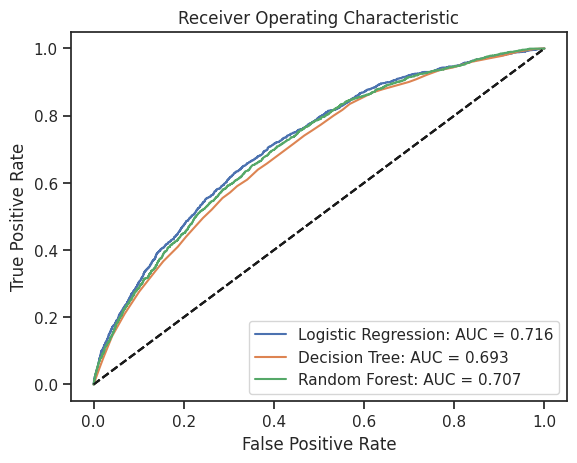

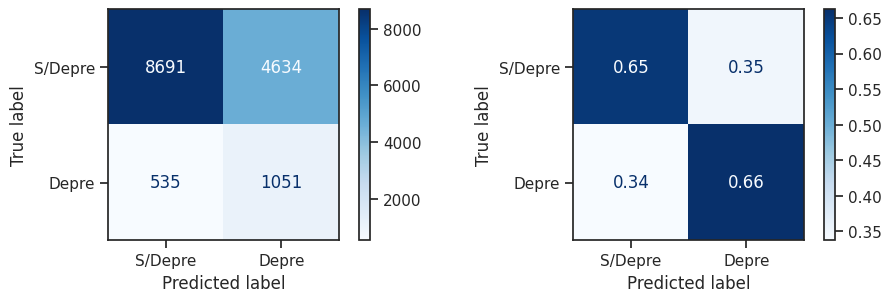

,exp,accuracy_train,precision_train,recall_train,f1_train,auc_train,accuracy_test,precision_test,recall_test,f1_test,auc_test
0,Logistic Regression,0.657621,0.192554,0.647179,0.296802,0.713971,0.653343,0.184872,0.662673,0.289094,0.715702
1,Decision Tree,0.626703,0.181577,0.668205,0.285558,0.701069,0.619878,0.169099,0.657629,0.269022,0.693269
2,Random Forest,0.602800,0.179240,0.714615,0.286596,0.712150,0.594796,0.169043,0.717528,0.273623,0.706694


In [67]:
df_total = process_df(df_train_total)

X = df_total.drop('depression', axis=1)
y = df_total['depression']

df_test =  process_df(df_test_total)
X_test = df_test.drop('depression', axis=1)
y_test = df_test['depression']

modeldict = {'Logistic Regression': model_log, 'Decision Tree': model_dt, 'Random Forest': model_rf}

plot_roc_curve(modeldict, X_test, y_test, path=PATH_GEN_DATA/'roc.png')
plot_cm(model_log, X_test, y_test, path=PATH_GEN_DATA/'cm.png')

metrics_test = classification_metrics(modeldict, X, y, X_test, y_test)
metrics_test.to_excel(PATH_GEN_DATA / 'test_metrics.xlsx')
metrics_test